# Project 3: Web APIs & NLP

Objectives & Requirements 
- Gather and prepare your data using the requests library.
- Create and compare two models. One of these must be a Bayes classifier, however the other can be a - classifier of your choosing: logistic regression, KNN, SVM, etc.
- A Jupyter Notebook with your analysis for a peer audience of data scientists.
- An executive summary of your results.
- A short presentation outlining your process and findings for a semi-technical audience.

#### Using Requests and Beautiful Soup to Extract Information From a Web Page

In [1]:
#import libraries 
import requests, json
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline, FeatureUnion 
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import r2_score
from sklearn import metrics
import time 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report 
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.datasets import make_classification
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

#### Pulling content by url and entering into a dataframe : 


In [2]:
# Defining different timestamps so we can loop through and pull enough data (9K) for each target subject
time_stamps = ['2019-12-28 15:07:53',
'2019-10-17 11:07:49',
'2019-08-26 19:11:01',
'2019-06-28 20:48:35',
'2019-04-13 23:00:50',
'2018-12-30 17:36:15',
'2018-09-03 18:17:58',
'2017-12-21 14:29:13',
'2017-02-16 16:40:38']

In [3]:
#Creating loop to pull data:

# set up list 
data_gw = []
data_cs = []
for time in time_stamps: 
    #text ={}
# select and target web page:    
    url = 'https://api.pushshift.io/reddit/submission/search'
#setting up parameters
    params_gw = {'subreddit': 'globalwarming', 'size': 1000, 'before':time}
    params_cs = {'subreddit': 'climateskeptics', 'size': 1000, 'before':time}
# Establishing the connection to the web page:
    res_gw = requests.get(url, params_gw)
    res_cs = requests.get(url, params_cs)
#check status codes to see if target server responds well - successful status code is confirmed.
    #print(res_gw.status_code)
    #print(res_cs.status_code)
# #Create two sets of dataframe for target subjects, converting requests to json and add to the list. 
    text_gw = pd.DataFrame(res_gw.json()['data'])
    text_cs = pd.DataFrame(res_cs.json()['data'])
    data_gw.append(text_gw)
    data_cs.append(text_cs)
    
#define 

    #for time in time_stamps:
        #time.sleep(3)

In [4]:
#Create two sets of dataframe for target subjects, concatenate 2 lists and dataframe 
frames = data_gw + data_cs
df = pd.concat(frames, axis = 0, sort=False)
df.reset_index(drop = True, inplace = True)

In [5]:
#data_gw[0]['score'].sum()

In [6]:
#data_cs[0]['score'].sum()

In [7]:
#merging title and texts into one field for richer content
df["title_selftext"] = df["title"] + " " + df["selftext"]

In [8]:
# removing non/blank values to remove data noise 
df['title_selftext'].dropna(axis = 0, inplace=True)
df['title_selftext']

0        Does big reports og forums exist with analysis...
1        It was 66 here in indiana on christmas day I a...
2        HELP, AUSTRALIA IS DYING AND NO ONE IS TALKING...
3        Global warming is BULLSHIT! I hate all this fa...
4        More Bullshit!!! "European cities will be sunk...
                               ...                        
17995           France to drop carbon tax plan: Les Echos 
17996                               The EPA Caves on Coal 
17997    California targets dairy cow farts to combat g...
17998    Why Climate Change Deniers Should Still Act On...
17999    UCS -stands for the Union of Con Scientists. L...
Name: title_selftext, Length: 17937, dtype: object

In [9]:
#Looking into dataframe to check the result
df = df[['title_selftext', 'subreddit']]
df['title_selftext'] = df['title_selftext'].astype(str)
df.head()

,title_selftext,subreddit
0,Does big reports og forums exist with analysis...,GlobalWarming
1,It was 66 here in indiana on christmas day I a...,GlobalWarming
2,"HELP, AUSTRALIA IS DYING AND NO ONE IS TALKING...",GlobalWarming
3,Global warming is BULLSHIT! I hate all this fa...,GlobalWarming
4,"More Bullshit!!! ""European cities will be sunk...",GlobalWarming


In [10]:
# Retrieved from Dan Kim feature_union notebook
# instantiate the sentiment analyzer 
sia = SentimentIntensityAnalyzer()
# Write a function to get the compound sentiment scores for a post
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

In [11]:
#Create and add sentiment column to the dataframe 
df['sentiment'] = df['title_selftext'].apply(lambda x: get_compound_sentiment(x))

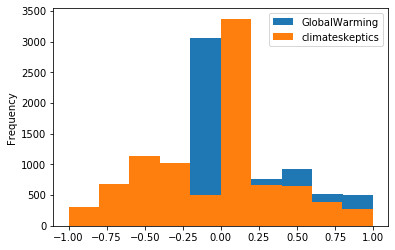

In [12]:
# look at the distribution of the composite sentiment score - Retrieved from Dan Kim feature_union notebook
df.groupby('subreddit')['sentiment'].plot(kind = 'hist', legend=True);

In [13]:
#Deep dive into negative posts for better undrestanding of what is driving it 
df[df['sentiment']<-0.5]

,title_selftext,subreddit,sentiment
3,Global warming is BULLSHIT! I hate all this fa...,GlobalWarming,-0.9956
4,"More Bullshit!!! ""European cities will be sunk...",GlobalWarming,-0.8777
5,A vet's hellish impressions of climate change,GlobalWarming,-0.5106
6,Am I… Am I really going to die at 47? 2050 is ...,GlobalWarming,-0.7916
12,What is worse for the planet? Carbon emissions...,GlobalWarming,-0.5362
...,...,...,...
17968,The climate scam corruption metastasizes,climateskeptics,-0.5719
17970,Two-thirds of Australians think reef crisis is...,climateskeptics,-0.7901
17981,Rampant climate fraud makes me doubt other hig...,climateskeptics,-0.9095
17983,"NASA Drops Global Warming BOMBSHELL, Liberals ...",climateskeptics,-0.7717


In [14]:
# Checking to see if all values are collected - all looks good!
df.subreddit.value_counts()

climateskeptics    9000
GlobalWarming      9000
Name: subreddit, dtype: int64

###  Pre-processing | Modeling | Evaluation:

In [15]:
# This process has been used to verify timestamp for data pull.
#df = df[['created_utc', 'retrieved_on','title_selftext', 'subreddit']]

In [16]:
# removing non/blank values to remove data noise 
df.dropna(inplace=True)

Converting subreddit into binary values: 

> - 0 for GlobalWarming
> - 1 for climateskeptics

In [17]:
df['subreddit'] = np.where(df['subreddit']=='climateskeptics', 1,0)
df['subreddit'].value_counts()

1    9000
0    9000
Name: subreddit, dtype: int64

#### Cleaning  | Pre-processing

In [18]:
#Removing urls
df['title_selftext'] = df['title_selftext'].map(lambda x: re.sub('http[s]?:\/\/[^\s]*', ' ', x)) # removing urls

In [19]:
#Removing all punctuation
df['title_selftext'] = df['title_selftext'].map(lambda x: re.sub('[^\w\s]', ' ', x)) # Removing all punctuation 

In [20]:
#Only keeping letters 
df['title_selftext'] = df['title_selftext'].map(lambda x: re.sub("[^a-zA-Z]", " ", x)) # Only keeping letter

In [21]:
#reindexing df to be able to merge column into new words_df dataframe
df.reset_index(inplace=True)

In [22]:
#using countervectorizer to tokenize our texts into collection of words 
words = df["title_selftext"]
#Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()
#Run lemmatizer.
tokens_lem =  [lemmatizer.lemmatize(i) for i in words]
# removing stopwords 
stop_words = stopwords.words('english')
filtered_words = [word for word in tokens_lem if word not in stop_words]

In [23]:
#using countervectorizer to tokenize our texts into collection of words 
cvec = CountVectorizer(min_df =10)
words_matrix = cvec.fit_transform(filtered_words)

In [24]:
#creating a datframe from all tokenized words  
words_df = pd.DataFrame(words_matrix.toarray(), columns=cvec.get_feature_names())
words_df['sentiment'] = df['sentiment']

In [25]:
#looking into top words by each class
top_words_gw = list(words_df.groupby('target').
     mean().T.sort_values(0, ascending=False).head(150).index)

top_words_cs = list(words_df.groupby('target').
     mean().T.sort_values(1, ascending=False).head(150).index)

print(top_words_gw)

['the', 'to', 'of', 'and', 'is', 'in', 'climate', 'that', 'it', 'global', 'warming', 'this', 'change', 'for', 'on', 'are', 'we', 'be', 'you', 'not', 'as', 'have', 'with', 'by', 'about', 'what', 'from', 'but', 'if', 'can', 'will', 'all', 'so', 'they', 'how', 'or', 'more', 'at', 'do', 'an', 'was', 'co', 'just', 'would', 'my', 'there', 'people', 'has', 'world', 'earth', 'years', 'our', 'removed', 'like', 'out', 'why', 'carbon', 'up', 'than', 'new', 'some', 'no', 'their', 'ice', 'science', 'one', 'could', 'temperature', 'now', 'me', 'don', 'us', 'scientists', 'time', 'which', 'been', 'because', 'any', 'over', 'your', 'much', 'planet', 'think', 'when', 'who', 'know', 'into', 'data', 'energy', 'here', 'year', 'only', 'these', 'even', 'amp', 'get', 'should', 'made', 'see', 'sea', 'water', 'make', 'most', 'help', 'solar', 'other', 'also', 'going', 'real', 'its', 'human', 'then', 'he', 'really', 'does', 'many', 'were', 'emissions', 'need', 'use', 'very', 'being', 'want', 'them', 'way', 'believe

In [26]:
print(top_words_cs)

['the', 'to', 'and', 'of', 'we', 'that', 'in', 'they', 'it', 'is', 'was', 'this', 'not', 'by', 'she', 'but', 'on', 'for', 'emissions', 'so', 'with', 'can', 'as', 'their', 'her', 'time', 'should', 'climate', 'more', 'if', 'just', 'are', 'like', 'or', 'many', 'about', 'how', 'where', 'because', 'still', 'targets', 'from', 'be', 'will', 'australia', 'here', 'see', 'people', 'tax', 'carbon', 'would', 'had', 'energy', 'our', 'up', 'power', 'other', 'any', 'big', 'government', 'don', 'do', 'problems', 'what', 'levels', 'me', 'historical', 'change', 'care', 'new', 'didn', 'attacked', 'even', 'my', 'said', 'you', 'know', 'strategy', 'being', 'conservative', 'ghg', 'over', 'set', 'nuclear', 'education', 'have', 'pay', 'past', 'reduce', 'believe', 'than', 'methane', 'water', 'were', 'reduction', 'idea', 'atmosphere', 'chemical', 'point', 'greenhouse', 'pollution', 'hold', 'gases', 'suggestions', 'suggestion', 'out', 'he', 'at', 'ice', 'election', 'calling', 'am', 'business', 'an', 'each', 'think

In [27]:
#setting up our data for modeling. X is all words column from the new df, Y is the subject label 
X = words_df
y = df['subreddit']

In [28]:
# split data into train/test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

### Tuning Models 

### Model 1 - Logistic Regression 

In [29]:
#Instantiate model
logreg =LogisticRegression(solver = 'liblinear')

In [30]:
#setting up parameters 
params_logreg = {'penalty': ['l1', 'l2']} # we use penalty to diffrentiate vs lasso and ridge

In [31]:
# using gridsearch to loop thorough the parameters and finds the best
gs_logreg = GridSearchCV(logreg, params_logreg, cv = 5)
gs_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

#### Model 1 - Evaluation

In [32]:
# Model Evaluation
# print out the best score
print(gs_logreg.best_score_)
#print out the set of hyperparameters that achieved the best score.
logreg_model = gs_logreg.best_estimator_
print('accuracy score - Existing data', logreg_model.score(X_train, y_train))
print('accuracy score - New data',  logreg_model.score(X_test, y_test)) # Accuracy score 

0.8233333333333334
accuracy score - Existing data 0.9068888888888889
accuracy score - New data 0.8342222222222222


In [33]:
# look int coefficients and put it into a dataframe
features = X
features = list(features)
coefs = gs_logreg.best_estimator_.coef_

In [34]:
simple_df = pd.DataFrame({'features': features, 'coefficients': coefs[0]})
simple_df

,features,coefficients
0,abandon,0.465461
1,abc,0.220815
2,ability,0.065879
3,able,-0.364832
4,about,0.144341
...,...,...
4267,zero,0.197319
4268,zharkova,0.481640
4269,zone,-0.325130
4270,zones,0.382683


### Model 2 -  Random Forest 

In [35]:
#instantiate the model
rf = RandomForestClassifier()

In [36]:
#setup paramaters & Gridsearch 
rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
}
gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [37]:
# print out the best score
print(gs_rf.best_score_)
#print out the set of hyperparameters that achieved the best score.
rf_model = gs_rf.best_estimator_
print('accuracy score - Existing data', rf_model.score(X_train, y_train))
print('accuracy score - New data', rf_model.score(X_test, y_test)) # Accuracy 

0.8879259259259259
accuracy score - Existing data 0.9935555555555555
accuracy score - New data 0.9004444444444445


### Model 3 - Ada Boost Classifier

This model took longer time than anticipated for large set of data, thus I wont be tuning it here. 

In [38]:
#ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [39]:
#ada_params = {
#    'n_estimators': [100,150],
#    'base_estimator__max_depth': [1,2],
#    'learning_rate': [.9, 1.]
#}
#gs_ada = GridSearchCV(ada, param_grid=ada_params, cv=3)
#gs_ada.fit(X_train, y_train)

In [40]:
## print out the best score
#print(gs_ada.best_score_)
##print out the set of hyperparameters that achieved the best score.
#ada_model = gs_ada.best_estimator_
#print('accuracy score - Existing data', ada_model.score(X_train, y_train))
#print('accuracy score - New data', ada_model.score(X_test, y_test)) # Accuracy 

### Model 4 - Gradient Boosting Classifier 

In [41]:
#Instantiate the model
gb = GradientBoostingClassifier()

In [43]:
# Setting up parameters and Gridsearch 
gb_params = {
   'max_depth': [2,3,4],
    'n_estimators': [100, 150],
    'learning_rate': [.08, .1, .12],
    #'max_features': [100]
}
gs_gb = GridSearchCV(gb, param_grid=gb_params, cv=3)
gs_gb.fit(X_train, y_train)

In [ ]:
# Model Evaluation
# print out the best score
print(gs_gb.best_score_)
#print out the set of hyperparameters that achieved the best score.
gb_model = gs_gb.best_estimator_
print('accuracy score - Existing data', gb_model.score(X_train, y_train))
print('accuracy score - New data', gb_model.score(X_test, y_test)) # Accuracy 

### Model 5 - Voting Classifier 

In [ ]:
#Instantiate model 




In [ ]:
# for the sake of time & speed no parameters were run for the votingclassifier
# but will keep/run the code for future references. 

##using GridSearch now to loop through multiple parameter and check which one works the best for our model:
## Fit GridSearch to train set.
#gs = GridSearchCV(vote, param_grid=vote_params, cv=3)
## Fit GridSearch to train set.
#gs.fit(X_train, y_train)
## print out the best score
#print(gs.best_score_)
##print out the set of hyperparameters that achieved the best score.
#print(gs.best_params_)
#vote_model = gs.best_estimator_
#print(vote_model.score(X_train, y_train))
#print(vote_model.score(X_test, y_test))

In [ ]:
#vote = VotingClassifier([
#    ('gb', GradientBoostingClassifier()), 
#    ('lr', LogisticRegression(solver = 'liblinear')),
#    ('rf', RandomForestClassifier())])
#
## setting up params n_estimators is set based on squareroot number of 20K rows ~150
##vote_params = {
##    'gb__n_estimators': [100,150],
##    'lr__n_estimators': [100,150],
##    'rf__max_depth': [None, 10],
#    
##}
##using GridSearch now to loop through multiple parameter and check which one works the best for our model:
## Fit GridSearch to train set.
#gs = GridSearchCV(vote, param_grid=vote_params, cv=3)
## Fit GridSearch to train set.
#gs.fit(X_train, y_train)
## print out the best score
#print(gs.best_score_)
##print out the set of hyperparameters that achieved the best score.
#print(gs.best_params_)
#vote_model = gs.best_estimator_
#print(vote_model.score(X_train, y_train))
#print(vote_model.score(X_test, y_test))